# Amazon Music Recommendations - PySpark ALS
## DATA612 - Recommender Systems
### Paul Perez and William Outcault

The goal of this project is to produce reliable recommendations at an efficient rate using a relatively large dataset (>1M ratings). Specifically we want to recommend music based off Amazon music reviews using Python, PySpark, and Alternating Least Squares (ALS) method.

The dataset was obtained from one of Amazon's Customer Review datasets (https://s3.amazonaws.com/amazon-reviews-pds/). Amazon provides a small sample of customer evaluations in order to help further research in a variety of disciplines, in our case we built an ALS model using Pyspark to recommend music for a large sum of individuals. The data contains reviews spanning from 1995 to 2015 in the form of ratings (1-5 stars).

After completing previous projects using R both of us felt that using Apache Spark with Python would be a great learning experience, and it would also be very applicable towards our future careers. The following report covers our data ingestion, exploratory data analysis, our ALS model, results and conclusion.

## Data Ingestion

We begin by loading the necessary modules for our model.

In [2]:
import pandas as pd
from sklearn import preprocessing
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

Amazon's customer digital music review dataset is loaded as a tsv (tab-separated values) file using pandas.

In [3]:
# Load Amazon Review Dataset of Digital Music Purchases as DataFrame
amz = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz',
                  sep='\t', error_bad_lines=False)

b'Skipping line 1686: expected 15 fields, saw 22\nSkipping line 23469: expected 15 fields, saw 22\nSkipping line 25225: expected 15 fields, saw 22\nSkipping line 48778: expected 15 fields, saw 22\nSkipping line 54061: expected 15 fields, saw 22\n'
b'Skipping line 66479: expected 15 fields, saw 22\nSkipping line 85019: expected 15 fields, saw 22\nSkipping line 102383: expected 15 fields, saw 22\nSkipping line 108349: expected 15 fields, saw 22\nSkipping line 111834: expected 15 fields, saw 22\nSkipping line 122189: expected 15 fields, saw 22\nSkipping line 124293: expected 15 fields, saw 22\n'
b'Skipping line 137493: expected 15 fields, saw 22\nSkipping line 138671: expected 15 fields, saw 22\nSkipping line 147213: expected 15 fields, saw 22\nSkipping line 156030: expected 15 fields, saw 22\nSkipping line 159108: expected 15 fields, saw 22\nSkipping line 162860: expected 15 fields, saw 22\nSkipping line 166640: expected 15 fields, saw 22\nSkipping line 174287: expected 15 fields, saw 22

When ingesting the dataset, some rows included a different length of field columns and therefore were skipped to maintain consistency. The number of rows skipped made up for less than 1% of the total rows therefore we concluded this would not significantly impact our model.

## Exploratory Data Analysis

Before we build the model lets perform exploratory data analysis on the dataset. We will eventually need to subset the dataframe depending on how many unique users and songs there are.

Firt lets view the shape of our dataset.

In [4]:
print('Dataframe shape: ',amz.shape)

Dataframe shape:  (1681484, 15)


We currently have 1,681,484 rows and 15 columns. Now lets view the contents of each column.

In [5]:
# Preview DataFrame
amz.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,10293599,R14LVB34Z2Z53I,B000YMOQZY,262935067,Knockin' On Heaven's Door,Digital_Music_Purchase,5.0,0.0,0.0,N,Y,favorites,Great rendition. Great song,2015-08-31
1,US,6087195,R2M0R9CWPC82LT,B00ISAEC80,452318038,Flawless,Digital_Music_Purchase,5.0,0.0,0.0,N,Y,Five Stars,A good music to listen.,2015-08-31
2,US,33717063,RQNQI2R3BM52A,B00VBB6AVU,675969129,Scandal of Grace,Digital_Music_Purchase,4.0,0.0,0.0,N,Y,Good,Not as good as the original but I needed to he...,2015-08-31
3,US,14948020,RTUIX1135HUAB,B008A5POJO,282925893,I Surrender (Live),Digital_Music_Purchase,5.0,0.0,0.0,N,Y,Wonderful lyrics! Makes you feel like praying,Time to worship and surrender with this song. ...,2015-08-31
4,US,21694522,RE3QSAT8TL010,B014CW2RN4,109077793,We Are Young (Jersey Club),Digital_Music_Purchase,4.0,0.0,0.0,N,Y,Hot remix but took short,So this should be longer....but love this song:),2015-08-31


Out of the 15 columns we will be focused on the customer ID, product ID, product title and star rating in order to create the appropriate dataframe for our ALS model.

In [20]:
# Slice DataFrame for Necessary Columns
cols = ['customer_id', 'product_id', 'product_title', 'star_rating']
amz_data = amz[cols]
amz_data

,customer_id,product_id,product_title,star_rating
0,10293599,B000YMOQZY,Knockin' On Heaven's Door,5.0
1,6087195,B00ISAEC80,Flawless,5.0
2,33717063,B00VBB6AVU,Scandal of Grace,4.0
3,14948020,B008A5POJO,I Surrender (Live),5.0
4,21694522,B014CW2RN4,We Are Young (Jersey Club),4.0
...,...,...,...,...
1681479,49890809,B0026GBMLM,The Human Condition In Twelve Fractions,5.0
1681480,49890809,B000TETLAW,Liberate te ex Inferis,5.0
1681481,46804575,B00138GY0I,Blood On The Dance Floor/ History In The Mix,4.0
1681482,49890809,B005NVYISQ,Satisfaction Is The Death Of Desire,5.0


We now have the appropiate dataset needed for implementing ALS through PySpark. However the size of the dataframe we want to model will have to be examined.

In [7]:
print('Number of Unique Songs: ',len(amz_data.product_id.unique()))

Number of Unique Songs:  699450


In [8]:
print('Number of Unique Users: ',len(amz_data.customer_id.unique()))

Number of Unique Users:  796587


Since we have almost 700k songs and 800k users we will need to take a sample. Our goal is to keep the most active 10k users.

In [92]:
n = 12000
top_customer_reviewers = amz_data.customer_id.value_counts()[:n]
amz_data_ss = amz_data[amz_data['customer_id'].isin(top_customer_reviewers.index)]
amz_data_ss

,customer_id,product_id,product_title,star_rating
4,21694522,B014CW2RN4,We Are Young (Jersey Club),4.0
6,20031966,B009G3U0PW,I'll Never Be Free,5.0
9,51714365,B00136NVH4,Bat Out Of Hell,5.0
24,3618115,B00O75PLY4,Live Wire,4.0
26,2024504,B007D59TBG,"Turandot: Act III - Calaf's Aria - ""Nessun dorma""",5.0
...,...,...,...,...
1681472,40057531,B0092MJOMW,Reign In Blood,5.0
1681474,53016962,B00138KFV2,The Bootleg Series Volumes 1-3 (Rare And Unrel...,5.0
1681478,42965654,B000QZX6X2,Chameleon,3.0
1681481,46804575,B00138GY0I,Blood On The Dance Floor/ History In The Mix,4.0


In [93]:
print('Number of Unique Songs: ',len(amz_data_ss.product_id.unique()))
print('Number of Unique Customers: ',len(amz_data_ss.customer_id.unique()))

Number of Unique Songs:  213206
Number of Unique Customers:  12000


In [94]:
n = 10000
top_movies_reviewed = amz_data_ss.product_id.value_counts()[:n]
amz_data_ss2 = amz_data_ss[amz_data_ss['product_id'].isin(top_movies_reviewed.index)]
amz_data_ss2

,customer_id,product_id,product_title,star_rating
9,51714365,B00136NVH4,Bat Out Of Hell,5.0
31,3618115,B00O75SGLE,Whole Lotta Rosie,4.0
37,22146246,B00T532QVO,Classic Man [Clean],4.0
41,14744748,B00C5ZORES,Save Rock And Roll [Explicit],5.0
60,14744748,B00KT3LJNU,Stay With Me,5.0
...,...,...,...,...
1680519,42418272,B000VZUIAQ,Chasing Cars,4.0
1680858,42418272,B000V6POF4,Wake Up Call,4.0
1681348,42418272,B000V63BN6,The Definitive Collection,4.0
1681406,42418272,B000VWLEFM,Made In England,5.0


In [95]:
print('Number of Unique Songs: ',len(amz_data_ss2.product_id.unique()))
print('Number of Unique Customers: ',len(amz_data_ss2.customer_id.unique()))

Number of Unique Songs:  10000
Number of Unique Customers:  10426


We got our ratings to be just over 1M (10k songs and about 10k customers) by choosing the most popular songs and most frequent reviewers.

Lets view the top-10 songs that were reviewed by customers, customers that reviewed the most songs and rating distribution.

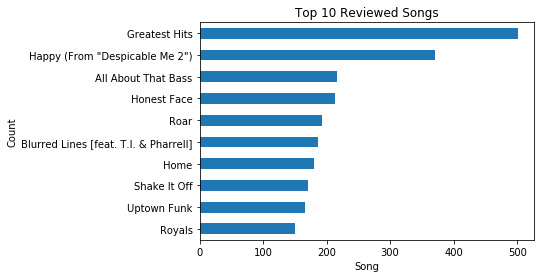

In [96]:
amz_data_ss2.product_title.value_counts()[:10].plot(kind='barh')
plt.title('Top 10 Reviewed Songs')
plt.ylabel('Count')
plt.xlabel('Song')
plt.gca().invert_yaxis()

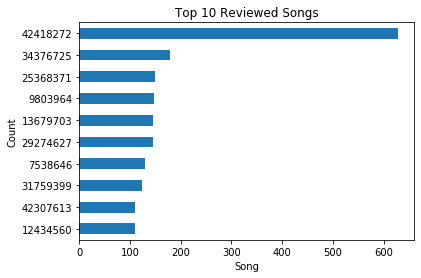

In [101]:
amz_data_ss2.customer_id.value_counts()[:10].plot(kind='barh')
plt.title('Customers that Reviewed the most Songs')
plt.ylabel('Count')
plt.xlabel('Song')
plt.gca().invert_yaxis()

Text(0.5, 0, 'Stars')

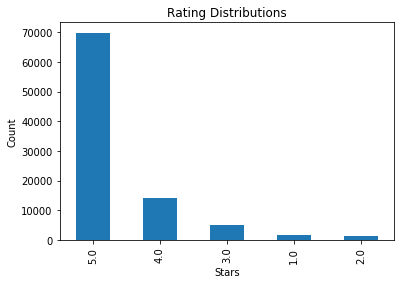

In [99]:
amz_data_ss2.star_rating.value_counts().plot(kind='bar')
plt.title('Rating Distributions')
plt.ylabel('Count')
plt.xlabel('Stars')

We have picked our most frequent reviewers and most popular songs while keeping the total number of ratings over one million. We have also seen the distribution of ratings is skewed, most are 5-stars while very few are below 3-stars. 

Lets create our model.

## Implementing Spark

We start by storing our dataframe in pyspark.

In [102]:
# Connect to SparkSession
start_time = time.time()
spark = SparkSession.builder.appName('PySpark ALS Recommender System').getOrCreate()
amz_spark = spark.createDataFrame(amz_data_ss2)
amz_spark.show()

+-----------+----------+--------------------+-----------+
|customer_id|product_id|       product_title|star_rating|
+-----------+----------+--------------------+-----------+
|   51714365|B00136NVH4|     Bat Out Of Hell|        5.0|
|    3618115|B00O75SGLE|   Whole Lotta Rosie|        4.0|
|   22146246|B00T532QVO| Classic Man [Clean]|        4.0|
|   14744748|B00C5ZORES|Save Rock And Rol...|        5.0|
|   14744748|B00KT3LJNU|        Stay With Me|        5.0|
|   45946560|B001NZP8B2|               Sunny|        5.0|
|   14744748|B00GM118JS|The Paradigm Shif...|        5.0|
|   14744748|B00FHAB7PK|       Wrecking Ball|        5.0|
|   21694522|B00O6K8HC8|       Back In Black|        5.0|
|   14744748|B00ESVFRA0|  Berzerk [Explicit]|        5.0|
|   39466736|B001HDUQCG|              Savior|        5.0|
|   15240638|B005DOJ8QK|       Fortunate Son|        5.0|
|   39466736|B0063A8XWS|Angels We Have He...|        5.0|
|   13822691|B001QSEI44|The Ballad Of Thu...|        5.0|
|   44564999|B

For ALS to work with Pyspark we must create numeric values for the customer and product ID's. We do this by taking their respective index values and applying those to be their new ID.

In [103]:
# Assign Every Unique Product ID, Customer ID, and Product Title an Index - Model Needs Numeric IDs
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(amz_spark.columns)-set(['star_rating'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(amz_spark).transform(amz_spark)
transformed.show()

+-----------+----------+--------------------+-----------+----------------+-----------------+-------------------+
|customer_id|product_id|       product_title|star_rating|product_id_index|customer_id_index|product_title_index|
+-----------+----------+--------------------+-----------+----------------+-----------------+-------------------+
|   51714365|B00136NVH4|     Bat Out Of Hell|        5.0|          2708.0|           4124.0|             2721.0|
|    3618115|B00O75SGLE|   Whole Lotta Rosie|        4.0|          9203.0|           1059.0|             7964.0|
|   22146246|B00T532QVO| Classic Man [Clean]|        4.0|          9256.0|           1675.0|             6323.0|
|   14744748|B00C5ZORES|Save Rock And Rol...|        5.0|          1510.0|            688.0|             1716.0|
|   14744748|B00KT3LJNU|        Stay With Me|        5.0|            36.0|            688.0|               23.0|
|   45946560|B001NZP8B2|               Sunny|        5.0|          3476.0|           7083.0|    

For recommendations later, we can map our unique song id's that we just generated to the song title's.

In [104]:
product_facts = transformed.select('product_id_index','product_title_index', 'product_title').drop_duplicates(subset = ['product_title_index']).toPandas()

We now split out dataframe into a 80/20 training and testing split.

In [ ]:
# Split DataFrame into Training and Test Sets - 80:20 Ratio
# Need to add Seed here
(training, test) = transformed.randomSplit([0.8, 0.2])

We create the ALS model by passing through the following parameters that we know; new customer and product ID, star rating, coldStartStrategy=drop and nonnegative=True. This way we do not predict negative values. Next we experimented with parameters which includes the rank, max iterations, and regularization parameter in order to minimize RMSE.

> Rank: Size of U and P matrices

> Max Iterations: to minimize error between U and P.

> Regularization Parameter: which prevents overfitting.

In [105]:
# ALS Model - 5 Iterations, RegParam 0.01
als = ALS(maxIter=5, regParam=0.05, userCol="customer_id_index", itemCol="product_id_index", ratingCol="star_rating",
          coldStartStrategy="drop", nonnegative=True)

Next we will fit the model using the training data.

In [106]:
als_spark_model = als.fit(training)

We predict the ratings for our test set, evaluate the model using root-mean-squared-error and print the result.

In [107]:
evaluator = RegressionEvaluator(metricName="rmse",labelCol="star_rating",predictionCol="prediction")
predictions = als_spark_model.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9559553745991212


Let's view the predictions.

In [108]:
predictions.show()

+-----------+----------+--------------------+-----------+----------------+-----------------+-------------------+----------+
|customer_id|product_id|       product_title|star_rating|product_id_index|customer_id_index|product_title_index|prediction|
+-----------+----------+--------------------+-----------+----------------+-----------------+-------------------+----------+
|   51064757|B00S17FZ7C|Love Me Like You ...|        5.0|           148.0|            348.0|               93.0| 4.8132563|
|   36922352|B00S17FZ7C|Love Me Like You ...|        5.0|           148.0|            484.0|               93.0|  3.565266|
|   43992277|B00S17FZ7C|Love Me Like You ...|        5.0|           148.0|           1079.0|               93.0|  4.685665|
|   23663191|B00S17FZ7C|Love Me Like You ...|        5.0|           148.0|           3302.0|               93.0| 5.0178094|
|   37656049|B00S17FZ7C|Love Me Like You ...|        3.0|           148.0|           2960.0|               93.0|  3.086508|
|   1038

We can now create song recommendations for each song in the dataset based on predictions.
We'll select 5 recommendations per song

In [109]:
# Create Pandas DataFrame to Product Recommendations
product_recs = als_spark_model.recommendForAllItems(5).toPandas()

In [ ]:
end_time = time.time()

Now we can see how long the model took to run

In [162]:
print("PySpark ALS Model Runtime: " + str((end_time - start_time)) + " seconds")

PySpark ALS Model Runtime: -3591.5944900512695 seconds


Now we can clean up the recommendations to get the song titles for each song.

In [110]:
recommendations = product_recs['recommendations'].apply(pd.Series)
recommendations = recommendations.rename(columns = lambda x : 'recommendation_' + str(int(x)+1))
recommendations = recommendations.apply(lambda col: col.str[0])
product_recs = pd.concat([product_recs[:], recommendations[:]], axis=1)

In [ ]:
product = product_recs['product_id_index'][0]
recommendation_1 = product_recs['recommendation_1'][0]
recommendation_2 = product_recs['recommendation_2'][0]
recommendation_3 = product_recs['recommendation_3'][0]
recommendation_4 = product_recs['recommendation_4'][0]
recommendation_5 = product_recs['recommendation_5'][0]

In [ ]:
product = product_facts[product_facts['product_id_index'] == product]['product_title']
recommendation_1 = product_facts[product_facts['product_id_index'] == recommendation_1]['product_title']
recommendation_2 = product_facts[product_facts['product_id_index'] == recommendation_2]['product_title']
recommendation_3 = product_facts[product_facts['product_id_index'] == recommendation_3]['product_title']
recommendation_4 = product_facts[product_facts['product_id_index'] == recommendation_4]['product_title']
recommendation_5 = product_facts[product_facts['product_id_index'] == recommendation_5]['product_title']

In [ ]:
print('Song: ',product)
print('Recomendation 1: ', recommendation_1)
print('Recomendation 2: ', recommendation_2)
print('Recomendation 3: ', recommendation_3)
print('Recomendation 4: ', recommendation_4)
print('Recomendation 5: ', recommendation_5)

In [ ]:
spark.catalog.clearCache()
spark.stop()

## Conclusion
The challenging part of this report was not only using a new dataset with over a million ratings, but learning how to build recommender systems using Python. We made this decision because of the popularity of Python in the commercial world also because we wanted to transcend our knowledge of recommender systems from R to Python.  